In [1]:
system_id = 1
kilometers = 0

In [2]:
import pandas as pd
import numpy as np
import torch
import os
from matplotlib import pyplot as plt

In [3]:
# Hyperparameters needed for a run:

# Data fetching
locations_used = 1
start_date = 2005
end_date = 2013
dwd_icon_vars = ['relhum_2m', 'aswdifd_s', 'aswdir_s', 't_2m', 'ww', 'clct']
open_meteo_names = ['relative_humidity_2m','diffuse_radiation', 'direct_radiation', 'temperature_2m', 'weather_code', 'cloud_cover']
dwd_path = os.path.expanduser("~/Path/to/DWD_ICON_EU/")

# Forecasting parameters
day_only = False
target = 'P'
past_features = ['P']
future_features = ['hour_sin','hour_cos']
weather_variables = False
lags = 24
forecast_period = 24
gap = 0 
forecast_gap = 0

# Lstm parameters
hidden_size = 400
num_layers = 3
dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
epochs = 200
batch_size = 32
learning_rate = 0.0001

## 1. Target location

In [4]:
data_aus = pd.read_parquet('../data/australia/aus_production.parquet', engine='pyarrow')
data_aus = data_aus[data_aus['Customer'] == system_id]
data_aus

,Customer,Postcode,Generator Capacity,Values,latitude,longitude
date,,,,,,
2011-07-01 00:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 00:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 02:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
...,...,...,...,...,...,...
2013-06-30 21:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078


In [5]:
# Hyperparams from the data
peak_power = data_aus['Generator Capacity'].iloc[0]
latitude = data_aus['latitude'].iloc[0]
longitude = data_aus['longitude'].iloc[0]

# Hyperparams not included in the data
tilt = 0
azimuth = 0
optimalangles = True

latitude, longitude, peak_power, tilt, azimuth

(-33.69699153381296, 151.13077966206853, 3.78, 0, 0)

In [6]:
# For data mis-specification
from src.util import formulas as fm

latitude, longitude = fm.calculate_new_position(latitude, longitude, kilometers, 125)

In [7]:
# Unique name for the data, model and metrics
data_name = 'australia' '_' + str(system_id) + '_' + str(kilometers) + 'km'
data_name

'australia_1_0km'

In [8]:
# Create the folders to save the data and models
data_folder = '../results/AUS/'
model_folder = '../models/AUS/' + data_name
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [9]:
data_aus

,Customer,Postcode,Generator Capacity,Values,latitude,longitude
date,,,,,,
2011-07-01 00:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 00:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 01:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2011-07-01 02:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
...,...,...,...,...,...,...
2013-06-30 21:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:00:00,1.0,2076,3.78,0.0,-33.696992,151.13078
2013-06-30 22:30:00,1.0,2076,3.78,0.0,-33.696992,151.13078


In [10]:
data_aus = pd.DataFrame(data_aus['Values'])
data_aus = data_aus.resample('H').sum()
data_aus = data_aus.rename(columns={"Values":"P"})

target_data = data_aus
target_data

,P
date,
2011-07-01 00:00:00,0.0
2011-07-01 01:00:00,0.0
2011-07-01 02:00:00,0.0
2011-07-01 03:00:00,0.0
2011-07-01 04:00:00,0.0
...,...
2013-06-30 19:00:00,0.0
2013-06-30 20:00:00,0.0
2013-06-30 21:00:00,0.0


## 2. Source location

In [15]:
# Import the datafetcher class
from src.data.datafetcher import PvFetcher

# Fetch data from PVGIS
data_PVGIS = PvFetcher(latitude,longitude,peak_power, tilt, azimuth, locations=locations_used, start_date=start_date, end_date=end_date,optimal_angles=1)

# Save the data in the data folder
#path = data.save_data(file_name = data_name + '/' + data_name)
#path

Gathering data from base location...


In [16]:
data = [data_PVGIS.dataset[0]]

In [17]:
data[0] = data[0].tz_localize('UTC').tz_convert('Australia/Sydney').tz_localize(None)
data[0] = data[0][13:-11]

In [18]:
data[0]

,P,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
time,,,,,,,,
2005-01-02 00:00:00,0.00,0.0,0.0,0.0,0.00,23.89,4.90,0
2005-01-02 01:00:00,0.00,0.0,0.0,0.0,0.00,23.79,4.97,0
2005-01-02 02:00:00,0.00,0.0,0.0,0.0,0.00,23.43,3.17,0
2005-01-02 03:00:00,0.00,0.0,0.0,0.0,0.00,22.27,3.66,0
2005-01-02 04:00:00,0.00,0.0,0.0,0.0,0.00,20.64,5.03,0
...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,48.99,0.0,28.8,0.0,6.45,22.06,4.76,0
2013-12-31 20:00:00,0.00,0.0,0.0,0.0,-4.61,21.48,4.00,0
2013-12-31 21:00:00,0.00,0.0,0.0,0.0,0.00,20.98,3.79,0


# 3. Featurisation

## 3.1 Source

Cyclical features

In [19]:
# Import the featurisation class
from src.data.featurisation import Featurisation

# Decide on the features to use in making the model (Note that 'P' should always be included since it's the target variable)
#dataset = Featurisation(data.dataset).base_features(features)
dataset = Featurisation(data).base_features(past_features)

# Use cyclic features as well
dataset = Featurisation(dataset).cyclic_features(yearly=True)
features = dataset[0].columns # update the features
source_data = dataset[0].copy()

Weather features

In [20]:
if weather_variables is True:
    from src.util.open_meteo_api import Open_meteo
    
    start = dataset[0].index[0].date()
    end = dataset[0].index[-1].date()
    target_end = target_data.index[-1].date()
    weather_fetcher = Open_meteo(latitude, longitude, start, target_end)
    
    weather_data = weather_fetcher.get_open_meteo_hourly()
    weather_data.set_index('date', inplace=True)
    weather_data = weather_data.tz_localize(None)
    
    source_data = pd.concat([dataset[0], weather_data], axis=1)
    source_data = source_data.loc[start:end]

In [21]:
source_data

,P,hour_sin,hour_cos,month_sin,month_cos
time,,,,,
2005-01-02 00:00:00,0.00,0.000000,1.000000,5.000000e-01,0.866025
2005-01-02 01:00:00,0.00,0.258819,0.965926,5.000000e-01,0.866025
2005-01-02 02:00:00,0.00,0.500000,0.866025,5.000000e-01,0.866025
2005-01-02 03:00:00,0.00,0.707107,0.707107,5.000000e-01,0.866025
2005-01-02 04:00:00,0.00,0.866025,0.500000,5.000000e-01,0.866025
...,...,...,...,...,...
2013-12-31 19:00:00,48.99,-0.965926,0.258819,-2.449294e-16,1.000000
2013-12-31 20:00:00,0.00,-0.866025,0.500000,-2.449294e-16,1.000000
2013-12-31 21:00:00,0.00,-0.707107,0.707107,-2.449294e-16,1.000000


In [22]:
domain_min = [0.0]
domain_max = [peak_power*0.86]

other_features = past_features[1:] + future_features

for i in range(len(other_features)):
    domain_min.append(min(source_data[other_features[i]]))
    domain_max.append(max(source_data[other_features[i]]))

## 3.2 Target

Cyclical features

In [23]:
target_featurisation = Featurisation([target_data])

In [24]:
target_data = target_featurisation.cyclic_features()[0]

Weather features

In [25]:
if weather_variables is True:
    from src.util.dwd_data_prep import Weather_data
    
    weather_data_target = Weather_data(dwd_path, latitude, longitude, dwd_icon_vars).get_weather_data()
    
    if 't_2m' in dwd_icon_vars:
        weather_data_target.t_2m = weather_data_target.t_2m - 272.15
        
    target_data = pd.concat([target_data, weather_data_target], axis=1)
    target_data = target_data.loc[:target_end]
    target_data.rename(columns=dict(zip(dwd_icon_vars, open_meteo_names)), inplace=True)


In [26]:
target_data.tail(5)

,P,hour_sin,hour_cos,month_sin,month_cos
date,,,,,
2013-06-30 19:00:00,0.0,-0.965926,0.258819,1.224647e-16,-1.0
2013-06-30 20:00:00,0.0,-0.866025,0.500000,1.224647e-16,-1.0
2013-06-30 21:00:00,0.0,-0.707107,0.707107,1.224647e-16,-1.0
2013-06-30 22:00:00,0.0,-0.500000,0.866025,1.224647e-16,-1.0
2013-06-30 23:00:00,0.0,-0.258819,0.965926,1.224647e-16,-1.0


# 4. Tensors

## 4.1 Source

In [27]:
from src.tensors.tensorisation import Tensors

In [28]:
src_tensors = Tensors(source_data, 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap)

In [29]:
X_train_src, X_test_src, y_train_src, y_test_src = src_tensors.create_tensor()
X_train_src.shape, X_test_src.shape, y_train_src.shape, y_test_src.shape

(torch.Size([2628, 24, 3]),
 torch.Size([657, 24, 3]),
 torch.Size([2628, 24]),
 torch.Size([657, 24]))

## 4.2 Target

In [30]:
target_excl_eval = target_data[:-365*24]

In [31]:
training_months = list(target_excl_eval.index.month.unique())

In [32]:
train_starts = []
for i in range(len(training_months)):
    train_start = target_excl_eval[(target_excl_eval.index.month ==training_months[i])].index[0]
    train_starts.append(train_start)
    
train_starts = list(reversed(train_starts))

In [33]:
X_train_target_list = []
X_test_target_list = []
X_eval_target_list = []
y_train_target_list = []
y_test_target_list = []
y_eval_target_list = []

for i in range(len(training_months)):
    tgt_tensors = Tensors(target_data.loc[train_starts[i]:], 'P', past_features , future_features, lags, forecast_period, gap=gap, forecast_gap=forecast_gap, evaluation_length=24*365, domain_min=domain_min, domain_max=domain_max)
    X_train_tgt, X_test_tgt, X_eval_tgt, y_train_tgt, y_test_tgt, y_eval_tgt = tgt_tensors.create_tensor()
    X_train_target_list.append(X_train_tgt)
    X_test_target_list.append(X_test_tgt)
    X_eval_target_list.append(X_eval_tgt)
    y_train_target_list.append(y_train_tgt)
    y_test_target_list.append(y_test_tgt)
    y_eval_target_list.append(y_eval_tgt) 
    print(X_train_tgt.shape, X_test_tgt.shape, X_eval_tgt.shape, y_train_tgt.shape, y_test_tgt.shape, y_eval_tgt.shape)

torch.Size([23, 24, 3]) torch.Size([6, 24, 3]) torch.Size([364, 24, 3]) torch.Size([23, 24]) torch.Size([6, 24]) torch.Size([364, 24])
torch.Size([48, 24, 3]) torch.Size([12, 24, 3]) torch.Size([364, 24, 3]) torch.Size([48, 24]) torch.Size([12, 24]) torch.Size([364, 24])
torch.Size([72, 24, 3]) torch.Size([18, 24, 3]) torch.Size([364, 24, 3]) torch.Size([72, 24]) torch.Size([18, 24]) torch.Size([364, 24])
torch.Size([97, 24, 3]) torch.Size([24, 24, 3]) torch.Size([364, 24, 3]) torch.Size([97, 24]) torch.Size([24, 24]) torch.Size([364, 24])
torch.Size([120, 24, 3]) torch.Size([30, 24, 3]) torch.Size([364, 24, 3]) torch.Size([120, 24]) torch.Size([30, 24]) torch.Size([364, 24])
torch.Size([145, 24, 3]) torch.Size([36, 24, 3]) torch.Size([364, 24, 3]) torch.Size([145, 24]) torch.Size([36, 24]) torch.Size([364, 24])
torch.Size([170, 24, 3]) torch.Size([42, 24, 3]) torch.Size([364, 24, 3]) torch.Size([170, 24]) torch.Size([42, 24]) torch.Size([364, 24])
torch.Size([194, 24, 3]) torch.Size([

In [34]:
X_train_src[0,:,0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0286, 0.1471, 0.2474,
        0.3192, 0.4425, 0.7099, 0.8027, 0.7106, 0.6460, 0.5615, 0.4969, 0.3302,
        0.1372, 0.0113, 0.0000, 0.0000, 0.0000, 0.0000])

# 5. Source model

In [36]:
# Import the lstm class to create an untrained LSTM
from src.models.lstm import LSTM

# Set the parameters for the lstm
input_size = len(past_features + future_features)

my_lstm = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
my_lstm

LSTM(
  (lstm): LSTM(3, 400, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=400, out_features=24, bias=True)
)

Step 0: Average train loss: 0.0304 | Average test loss: 0.0124
Step 5: Average train loss: 0.0088 | Average test loss: 0.0080
Step 10: Average train loss: 0.0084 | Average test loss: 0.0077
Step 15: Average train loss: 0.0082 | Average test loss: 0.0075
Step 20: Average train loss: 0.0081 | Average test loss: 0.0075
Step 25: Average train loss: 0.0080 | Average test loss: 0.0075
Step 30: Average train loss: 0.0079 | Average test loss: 0.0074
Step 35: Average train loss: 0.0079 | Average test loss: 0.0073
Step 40: Average train loss: 0.0078 | Average test loss: 0.0073
Step 45: Average train loss: 0.0077 | Average test loss: 0.0072
Step 50: Average train loss: 0.0077 | Average test loss: 0.0071
Step 55: Average train loss: 0.0076 | Average test loss: 0.0071
Step 60: Average train loss: 0.0076 | Average test loss: 0.0070
Step 65: Average train loss: 0.0075 | Average test loss: 0.0070
Step 70: Average train loss: 0.0075 | Average test loss: 0.0070
Step 75: Average train loss: 0.0075 | Aver

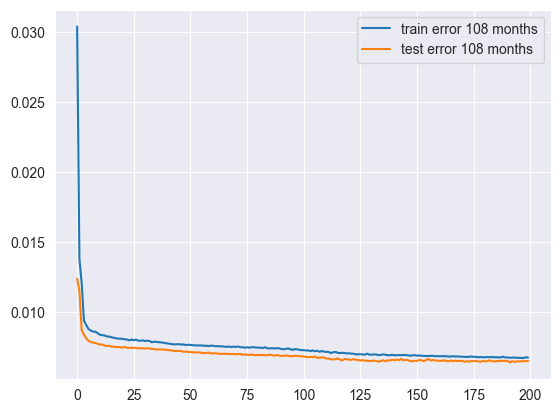

In [37]:
# Import the training class to train the model
import src.models.training as train
 
# Initialize the trainer
training = train.Training(my_lstm, X_train_src, y_train_src, X_test_src, y_test_src, epochs,batch_size=batch_size, learning_rate=learning_rate)

# Train the model and return the trained parameters and the best iteration
state_dict_list, best_epoch = training.fit()

In [38]:
# Load the state dictionary of the best performing model
my_lstm.load_state_dict(state_dict_list[best_epoch])

# Save the model state dictionary for later use 
train.save_model(my_lstm, 'AUS/' + data_name + '/model_' + data_name + '_transfer_0')

In [39]:
# Forecast with the model
forecasts = my_lstm(X_test_src.to(device))

In [40]:
# Import the evaluation script
from src.evaluation.evaluation import Evaluation

# Evaluate the model performance
source_eval = Evaluation(y_test_src.detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

# Show the evaluation metrics
source_eval.metrics()

,RMSE,Var(x),Var(y),Corr,Bias,Conditional bias 1,Resolution,Conditional bias 2,Discrimination
Metrics,0.080,0.058,0.047,0.945,0.000,0.006,0.058,0.006,0.058


# 6. Target model

In [41]:
# Set the parameters for the lstm
input_size = len(past_features + future_features)

# Create empty models for each of the periods
lstms = []

for i in range(len(training_months)+1):
    lstms.append(LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device))
    
torch.save(lstms[0].state_dict(), '../models/AUS/' + data_name + '/model_' + data_name + '_target_0')

Step 0: Average train loss: 0.0453 | Average test loss: 0.0486
Step 5: Average train loss: 0.0403 | Average test loss: 0.0431
Step 10: Average train loss: 0.0352 | Average test loss: 0.0371
Step 15: Average train loss: 0.0286 | Average test loss: 0.0290
Step 20: Average train loss: 0.0190 | Average test loss: 0.0168
Step 25: Average train loss: 0.0116 | Average test loss: 0.0080
Step 30: Average train loss: 0.0110 | Average test loss: 0.0064
Step 35: Average train loss: 0.0111 | Average test loss: 0.0087
Step 40: Average train loss: 0.0111 | Average test loss: 0.0081
Step 45: Average train loss: 0.0105 | Average test loss: 0.0064
Step 50: Average train loss: 0.0106 | Average test loss: 0.0062
Step 55: Average train loss: 0.0104 | Average test loss: 0.0067
Step 60: Average train loss: 0.0105 | Average test loss: 0.0070
Step 65: Average train loss: 0.0102 | Average test loss: 0.0067
Step 70: Average train loss: 0.0101 | Average test loss: 0.0064
Step 75: Average train loss: 0.0100 | Aver

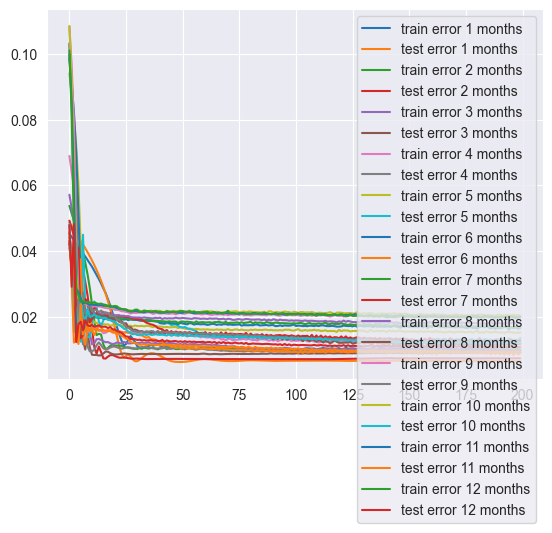

In [42]:
target_best_epochs = [0]

for i in range(len(training_months)):
    # Initialize the trainer
    training = train.Training(lstms[i+1], X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], epochs, learning_rate=learning_rate)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    lstms[i+1].load_state_dict(state_dict_list[best_epoch])
    target_best_epochs.append(best_epoch)

In [43]:
target_RMSEs = []

# Evaluate a clean model
forecasts = lstms[0](X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = lstms[i+1](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    target_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

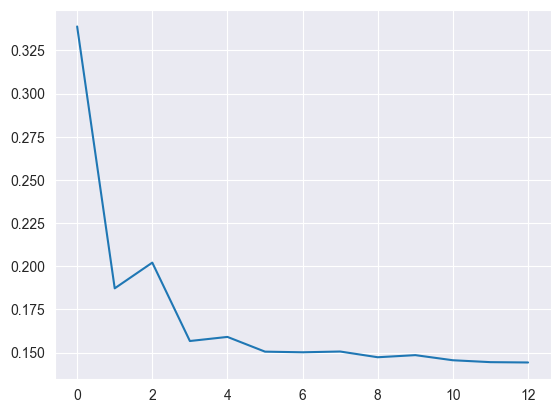

In [44]:
plt.plot(target_RMSEs)

# 7. Transfer model

In [45]:
# Layers to freeze

freezing = []

for name, _ in my_lstm.lstm.named_parameters():
    freezing.append(name)
    
freezing = freezing[:4]
freezing

['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0']

Step 0: Average train loss: 0.0141 | Average test loss: 0.0093
Step 5: Average train loss: 0.0138 | Average test loss: 0.0093
Step 10: Average train loss: 0.0142 | Average test loss: 0.0093
Step 15: Average train loss: 0.0140 | Average test loss: 0.0092
Step 20: Average train loss: 0.0134 | Average test loss: 0.0092
Step 25: Average train loss: 0.0130 | Average test loss: 0.0092
Step 30: Average train loss: 0.0137 | Average test loss: 0.0092
Step 35: Average train loss: 0.0134 | Average test loss: 0.0091
Step 40: Average train loss: 0.0136 | Average test loss: 0.0091
Step 45: Average train loss: 0.0141 | Average test loss: 0.0091
Step 50: Average train loss: 0.0130 | Average test loss: 0.0091
Step 55: Average train loss: 0.0133 | Average test loss: 0.0091
Step 60: Average train loss: 0.0132 | Average test loss: 0.0090
Step 65: Average train loss: 0.0132 | Average test loss: 0.0090
Step 70: Average train loss: 0.0135 | Average test loss: 0.0090
Step 75: Average train loss: 0.0130 | Aver

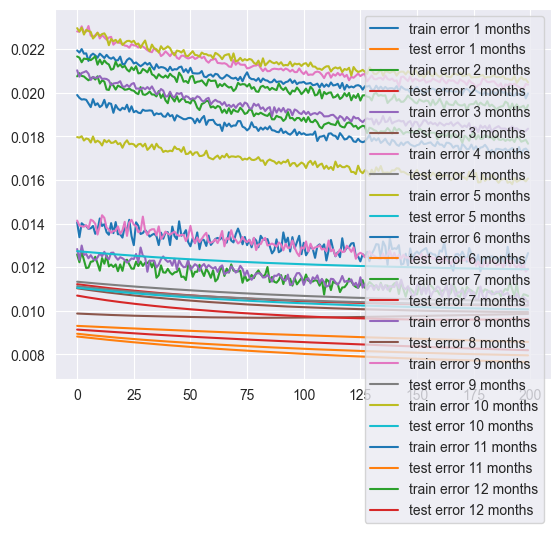

In [46]:
transfer_models = []
transfer_best_epochs = [0]

for i in range(len(training_months)):
    transfer_model  = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
    transfer_model.load_state_dict(torch.load('../models/AUS/' + data_name + '/model_' + data_name + '_transfer_0'))
       
    for name, param in transfer_model.lstm.named_parameters():
        if any(freezing_name in name for freezing_name in freezing):
            param.requires_grad = False

    # Initialize the trainer
    training = train.Training(transfer_model, 
                              X_train_target_list[i], y_train_target_list[i], X_test_target_list[i], y_test_target_list[i], 
                              epochs=epochs, batch_size = batch_size, learning_rate =learning_rate/100)

    # Train the model and return the trained parameters and the best iteration
    state_dict_list, best_epoch = training.fit()
    
    # Load the state dictionary of the best performing model
    transfer_model.load_state_dict(state_dict_list[best_epoch])
    
    transfer_best_epochs.append(best_epoch)
    transfer_models.append(transfer_model)

In [47]:
transfer_RMSEs = []

# Evaluate a clean model

transfer_model = LSTM(input_size,hidden_size,num_layers, forecast_period, dropout).to(device)
transfer_model.load_state_dict(torch.load('../models/AUS/' + data_name + '/model_' + data_name + '_transfer_0'))

forecasts = transfer_model(X_eval_target_list[0].to(device))
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = transfer_models[i](X_eval_target_list[i].to(device))
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    transfer_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

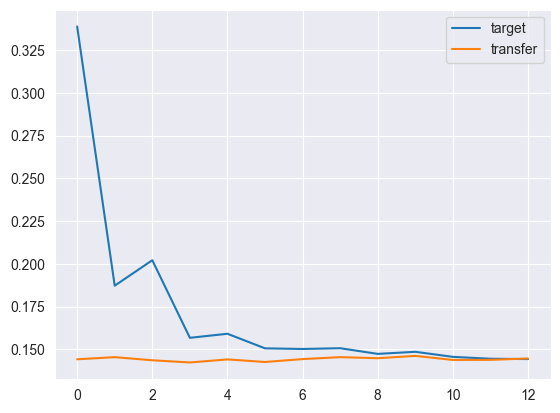

In [48]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.legend()

# 8. Baseline

In [49]:
baseline_RMSEs = []

# Evaluate a clean model
forecasts = X_eval_target_list[0][:,:,0]
source_eval = Evaluation(y_eval_target_list[0].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

for i in range(len(training_months)):
    # Forecast with the model
    forecasts = X_eval_target_list[i][:,:,0]
    # Evaluate the model performance
    source_eval = Evaluation(y_eval_target_list[i].detach().flatten().numpy(), forecasts.cpu().detach().flatten().numpy())

    # Show the evaluation metrics
    baseline_RMSEs.append(source_eval.metrics()['RMSE'].values[0])

# 9. Final visualisation and export

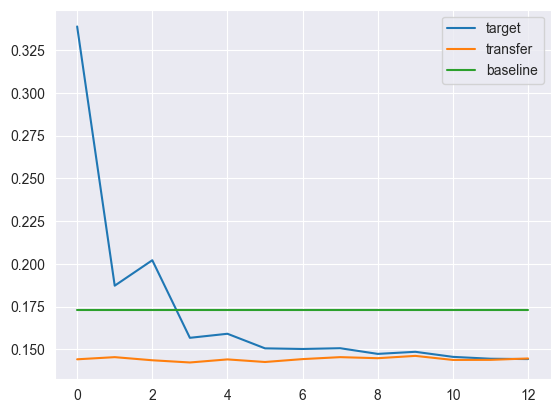

In [50]:
plt.plot(target_RMSEs,label='target')
plt.plot(transfer_RMSEs,label='transfer')
plt.plot(baseline_RMSEs, label='baseline')
plt.legend()

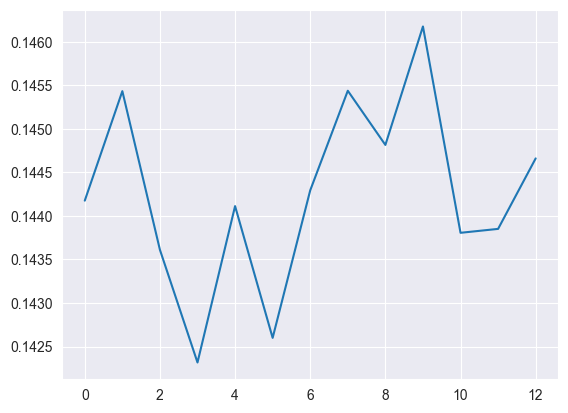

In [51]:
plt.plot(transfer_RMSEs,label='transfer')

In [52]:
column_names = []

for i in range(len(training_months)+1):
    column_names.append(str(i) + 'm')

In [53]:
all_metrics = pd.DataFrame([baseline_RMSEs, target_RMSEs, transfer_RMSEs, target_best_epochs, transfer_best_epochs],columns=column_names, index=['Baseline RMSE', 'Target RMSE', 'Transfer RMSE', 'Target epoch', 'Transfer epoch']).transpose()
all_metrics['Target epoch'] = all_metrics['Target epoch'].astype(int)
all_metrics['Transfer epoch'] = all_metrics['Transfer epoch'].astype(int)
all_metrics['Transfer epoch'] = all_metrics['Transfer epoch'].astype(int)
all_metrics

,Baseline RMSE,Target RMSE,Transfer RMSE,Target epoch,Transfer epoch
0m,0.173,0.339,0.144,0,0
1m,0.173,0.187,0.145,49,199
2m,0.173,0.202,0.144,99,199
3m,0.173,0.157,0.142,13,81
4m,0.173,0.159,0.144,109,199
5m,0.173,0.151,0.143,5,199
6m,0.173,0.150,0.144,196,199
7m,0.173,0.151,0.145,187,198
8m,0.173,0.147,0.145,179,199
9m,0.173,0.149,0.146,198,199


In [54]:
all_metrics.to_csv('../results/AUS/' + 'summary_table_' + data_name + '.csv')

In [55]:
data_name

'australia_1_0km'